LangChain을 활용한 MASTA AI Agent 만들기
=======================================

Open AI API Load
---

In [1]:
# OpenAI API 웹사이트 접속 : https://platform.openai.com/docs/overview


# API Key를 환경변수로 관리하기 위한 설정파일
from dotenv import load_dotenv

# API Key 정보 로드     
load_dotenv()



True

LangSmith
---

In [2]:

# LangSmith 추적 설정. https://smith.langchain.com
# .env 파일에 LangChain API Key를 입력합니다.

from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("MASTA_GenAI")

LangSmith 추적을 시작합니다.
[프로젝트명]
MASTA_GenAI


LLM 정의
---

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage

from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.tools.python.tool import PythonAstREPLTool

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm2 = ChatOpenAI(model="gpt-4o", temperature=0)

# LLM 1번 (기어박스 정보 수집기)
## Prompt 정의
prompt1 = ChatPromptTemplate.from_messages(
    [
        # role, message
        (
            "system", 
            """
            # 당신은 기어박스 설계를 위한 정보수집자로, 기계 설계 및 동력 전달 시스템에 대한 전문 지식을 보유하고 있습니다. 
            # 당신은 사용자로부터 기어박스 설계에 필요한 정보를 명확하고 체계적으로 추출합니다.
            # 사용자가 제공한 필수 정보 항목들이 모두 입력되었는지 확인한 후, 누락된 항목이 있을 경우 추가 요청하여 정보를 수집합니다. 필수 정보는 다음과 같습니다:

                1) 요구수명 (단위: hr)
                2) 입력속도 (단위: RPM)
                3) 부하토크 (단위: N.m)
                4) 작동온도 (단위: deg)
                5) 입출력 기어비

            # 필수 정보가 모두 입력될 때까지 반복적으로 요청하여 기어박스 설계를 원활하게 수행합니다. 
            # 누락된 정보는 하나씩 요청하지 말고 한꺼번에 요청하세요.
            # 함부로 추측하여 정보를 입력하시 마세요.
            # 답변은 간결하고 명확하게 전달하며, 기어박스 설계에 불필요한 정보를 배제합니다."""
         ),
         (
             "ai",
             """안녕하세요! 기어박스 설계를 도와드리겠습니다. 아래의 정보를 입력해주세요!
                1) 요구수명 (단위: hr)
                2) 입력속도 (단위: RPM)
                3) 부하토크 (단위: N.m)
                4) 작동온도 (단위: deg)
                5) 입출력 기어비
            """
         ),
         ("placeholder", "{messages}"),
    ]
)

## Tool 정의
### 기어박스 정보분류기
from typing import Union

class GearBoxData(BaseModel):
    """기어박스 설계 시 필요한 필수 정보"""
    life_hours: float = Field(..., description="요구수명 (단위: hr)")
    input_speed: float = Field(..., description="입력속도 (단위: RPM)")
    load_torque: float = Field(..., description="부하토크 (단위: N.m)")
    operating_temp: float = Field(..., description="작동온도 (단위: deg)")
    gear_ratio: float = Field(..., description="입출력 기어비")

class AdditionalQuestion(BaseModel):
    """ 기어박스 설계 시 필요한 정보를 유저에게 요청 """
    question: str = Field(...,description="기어박스 설계 시 필요한 정보를 요청하기 위한 추가적인 질문")

class GearBoxChatBotResponse(BaseModel):
    """ 챗봇의 응답값으로, 기어박스 설계 시 필요한 정보가 부족한 경우, 필요한 필수 정보를 추가적으로 유저에게 질문하고, 기어박스 설계 시 필요한 필수 정보를 받환 받으면 유저에게 보여준 후 종료합니다. """
    response: Union[AdditionalQuestion, GearBoxData] =  Field(..., description="챗봇의 응답")

## LLM 활용 정의
llm_with_tool1 = llm.with_structured_output(GearBoxChatBotResponse)

## Chain 정의
chain1 = prompt1 | llm_with_tool1


In [4]:
# LLM 2번 (기어박스 설계자)
## Prompt 정의
prompt2 = ChatPromptTemplate.from_messages(
    [
        # role, message
        (
            "system", 
            """
            # 당신은 숙련된 기어박스 설계자로, 기계 설계 및 동력 전달 시스템에 대한 전문 지식을 보유하고 있습니다. 
            # 당신은 사용자로부터 기어박스 설계에 필요한 정보를 명확하고 체계적으로 추출하고 추출된 정보로 기어박스를 설계합니다.
            # 당신에게 전달될 필수 정보는 아래의 5가지입니다.

                1) 요구수명 (단위: hr)
                2) 입력속도 (단위: RPM)
                3) 부하토크 (단위: N.m)
                4) 작동온도 (단위: deg)
                5) 입출력 기어비

            # 필수 정보가 모두 수집되면 사용자로부터 입력된 정보를 기반으로 기어박스를 설계합니다. 
            # 설계를 위해 반드시 지켜야하는 프로세스는 아래와 같습니다.
            # 각 프로세스는 단계별로 수행되어야 합니다.

                1) 입력된 기어비를 분석하여 필요한 평기어 쌍의 개수를 결정합니다.
                    - 기어 한쌍의 최대 허용 기어비는 [4] 입니다. 
                    - 기어비를 여러 개의 기어 쌍으로 분배할 경우 각 기어 쌍의 기어비는 비슷한 수준으로 분배합니다. 예를 들어 기어비가 8이면 [기어비=pow(8, 1/2)] 이런 식으로 기어비를 배분합니다.
                2) 입력된 요구수명, 속도, 토크를 활용하여 평기어 쌍을 설계합니다. 설계 후 도출되는 평기어 쌍 별 제원은 아래와 같습니다. 
                    (만약 필요한 평기어 쌍이 2개라면 아래 제원은 2개씩 도출됩니다.)
                    (평기어 쌍의 제원은 입력되는 토크에 따라 달라져야 합니다.)
                    - 평기어 쌍의 공통 제원 (모듈, 압력각, 헬리컬각)
                    - 평기어 쌍의 피니언 기어 제원 (잇수, 치폭)
                    - 평기어 쌍의 휠 기어 제원 (잇수, 치폭)                    
                    - 평기어 쌍의 중심거리 = (피니언 잇수 + 휠 잇수) * 모듈 / (2 * cos(헬리컬각*pi/180) 으로 계산합니다. 여기서 헬리컬각은 deg, 모듈은 mm 단위입니다. 
                3) 기어가 장착되기 위해 필요한 축의 수를 결정합니다.
                    - 기어 한쌍은 2개의 기어로 구성되므로, 기어 한쌍을 장착하기 위한 축의 수는 [2]개입니다.
                    - 기어가 두쌍이라면 총 4개의 기어로 구성되지만, 첫번째 기어 쌍의 휠기어와 두번째 기어 쌍의 피니언 기어는 같은 축에 장착되기 때문에 기어 장착에 필요한 축의 수는 [3]개입니다.
                4) 축의 길이와 직경을 결정합니다.
                5) 축의 위치를 결정합니다. (xyz 좌표)
                    - 축의 반경방향 거리는 장착되는 기어 쌍의 중심거리에 맞게 결정되어야 합니다.                    
                6) 축의 기어 장착 위치를 결정합니다.
                    - 피니언 기어와 휠 기어의 치면 중심위치는 동일해야 합니다.
                    - 만약 동일한 축에 서로 다른 기어쌍의 기어가 여러개 장착되는 경우 축의 중심부에 적절히 배치하여 반드시 서로 겹치지 않도록 합니다. 
                    - 예를 들어 축 길이가 300이고, 장착되는 기어가 2개라면 A기어는 축의 길이방향 1/3 지점인 100에 위치하고 B기어는 축의 길이방향 2/3 지점인 200에 위치시킵니다.
                7) 축을 안정적으로 지지하기 위한 베어링의 갯수를 결정합니다. 
                    - 축 1개당 일반적으로 2개의 베어링이 장착됩니다.
                8) 축을 안정적으로 지지하기 위한 베어링의 장착 위치를 결정합니다.
                    - 베어링은 일반적으로 축의 양 끝단에 위치합니다.

            # 설계 후 [Code Generator]에게 각 프로세스 별로 구분하여 도출된 설계결과를 전달합니다.
            # 답변은 간결하고 명확하게 전달하며, 기어박스 설계에 불필요한 정보를 배제합니다."""
         ),
        ("placeholder", "{messages}"),
    ]
)

## Chain 정의
chain2 = prompt2 | llm2

In [5]:
# LLM 3번 (MASTA Code 생성기)
## Prompt 정의
prompt3 = ChatPromptTemplate.from_messages(
    [
        # role, message
        (
            "system", 
            """
            # This GPT assists users in generating API code for running software (SW) that focuses on designing gearboxes, with a specialization in Python-based API code. 
            # All code snippets include the following initialization block for mastapy before any other API functionality:

            ```python
            # mastapy 초기화
            import math
            import Utility
            import mastapy
            from mastapy import init

            init(r'C:\Program Files\SMT\MASTA 13.0.3')

            # 새로운 Design 작성
            from mastapy.system_model import Design

            my_design = Design()

            # Root assembly 변수에 할당
            assembly = my_design.root_assembly

            # 단위 환산 준비
            MM = 1e-3
            RAD = math.pi/180
            RPM = 2*math.pi/60
            ```

            # 기어박스 모델링은 아래의 넘버링 순으로 진행됩니다. 아래의 순서에 따라 순서대로 코드를 생성해주세요.
            1) 기어 생성
            - 설계자의 요구에 따라 필요한 기어 쌍을 생성합니다.
            - A cylindrical gear consists of two spur gears in a pair. 

            Example for creating a gear pair:
            ```python
            Centerdistance = 100
            gearpair = assembly.add_cylindrical_gear_pair(Centerdistance*MM)
            ```

            2) 기어 제원 수정
            - 설계자의 요구에 따라 모듈을 제외한 기어 쌍의 제원을 수정합니다.
            - 기어 쌍의 모듈은 주어진 중심거리에 따라 수정합니다. 
            - 기어의 중심거리에 따른 모듈는 아래의 파이선 코드 예제를 이용하여 계산합니다.
            ```python
            m_n = Utility.calculate_normal_module(Centerdistance, z1, z2, beta)
            gearpair.active_gear_set_design.normal_module = m_n * MM          
            ```

            - Common specifications such as normal module, helical angle, and pressure angle can be modified as in the example below according to the user's instructions.
            ```python
            beta = 0
            alpha_n = 20

            gearpair.active_gear_set_design.helix_angle = beta * RAD
            gearpair.active_gear_set_design.normal_pressure_angle_maintain_transverse_profile = alpha_n*RAD
            ```

            - Set Pinion and Wheel Gear Properties
            - Define `pinion` and `wheel` for individual gear settings:
            ```python
            pinion = gearpair.active_gear_set_design.cylindrical_gears[0]
            wheel = gearpair.active_gear_set_design.cylindrical_gears[1]
            z1 = 40	# number of teeth, pinion
            z2 = 61	# number of teeth, wheel
            b1 = 10	# facewidth of pinion
            b2 = 11	# facewidth of wheel

            pinion.number_of_teeth = z1
            wheel.number_of_teeth = z2
            pinion.face_width = b1 * MM
            wheel.face_width = b2 * MM
            ```

            - Set Pinion and Wheel Gear Basic Rack Profile
            - Example codes for setting addendum/dedendum in the gear base rack tooth profile are as follows.
            - For pinion
            ```python
            adden = 1 # Addendum coefficient of gear base rack, dimensionless number divided by mm module.
            deden = 1.25 # Dedenum coefficient of gear base rack, dimensionless number divided by mm module.
            rootR = 0.3 # Root radius of gear base rack, dimensionless number divided by mm module. 
            pinion.cylindrical_gear_cutting_options.cylindrical_gear_cutter.basic_rack_addendum_factor = adden
            pinion.cylindrical_gear_cutting_options.cylindrical_gear_cutter.basic_rack_dedendum_factor = deden
            pinion.cylindrical_gear_cutting_options.cylindrical_gear_cutter.both_flanks.edge_radius_factor= rootR
            ```          

            3) 축 생성
            - 설계자의 요구에 따라 필요한 축을 생성합니다.
            - 축을 생성하기 위한 예시는 아래와 같습니다.
            To add a shaft to the gearbox design:
            ```python
            L = 160
            do = 40
            di = 0
            shaft = assembly.add_shaft(length=L*MM, outer_diameter=do*MM, bore=di*MM)
            ```

            4) 축 배치
            - By default, the shaft aligns parallel to the Z-axis.
            - X and Y coordinates define the inter-shaft distance.
            - 축 사이의 간격은 장착되는 기어의 중심거리와 동일해야 합니다. 즉, "x^2 + y^2 = 기어중심거리^2" 과 같습니다. 기어의 중심거리는 전달된 값이 아닌 계산된 값을 사용합니다.

            For 3D positioning using XYZ coordinates:
            ```python
            X = 10
            Y = 20
            Z = 0
            ShaftNumber = 0  # 축 생성 순서
            desiredPosition = mastapy._math.vector_3d.Vector3D(X,Y,Z)*MM
            my_design.root_assembly.shafts[ShaftNumber].set_position_of_component_and_connected_components(desiredPosition)
            ```

            5) 기어 배치
            ### Gear Mounting on Shafts
            - To mount a gear, you must redefine the pinion and wheel as follows:
            ```python
            pinion1_mount = gearpair1.cylindrical_gears[0]
            wheel1_mount = gearpair1.cylindrical_gears[1]
            pinion2_mount = gearpair2.cylindrical_gears[0]
            wheel2_mount = gearpair2.cylindrical_gears[1]
            ```

            - If the longitudinal coordinates of the two shafts differ, position the gears so that the tooth faces align based on the relative shaft positions. For instance, if shaft1's longitudinal position is 0 and shaft2's is 10, a pinion positioned 20 mm along shaft1 would require the wheel to be positioned 10 mm along shaft2 to ensure alignment:
            - 만약 동일한 축에 서로 다른 기어쌍의 기어가 여러개 장착되는 경우 축의 중심부에 적절히 배치하여 반드시 서로 겹치지 않도록 합니다. 
            - 예를 들어 축 길이가 300이고, 장착되는 기어가 2개라면 A기어는 축의 길이방향 1/3 지점인 100에 위치하고 B기어는 축의 길이방향 2/3 지점인 200에 위치시킵니다.
            - 기어 쌍의 피니언 기어와 휠 기어의 치면 중심위치는 동일해야 합니다.

            ```python
            pinion1_zPosition = 100  # Position along the shaft length from the origin in mm
            wheel1_zPosition = 100  # Position along the shaft length from the origin in mm
            pinion2_zPosition = 200  # Position along the shaft length from the origin in mm
            wheel2_zPosition = 200  # Position along the shaft length from the origin in mm
            ```
            
            - After all settings are complete, mount the gear on the shaft as shown below:
            ```python
            shaft1.mount_component(pinion1_mount, pinion1_zPosition*MM)
            shaft2.mount_component(wheel1_mount, wheel1_zPosition*MM)
            shaft2.mount_component(pinion2_mount, pinion2_zPosition*MM)
            shaft3.mount_component(wheel2_mount, wheel2_zPosition*MM)
            ```

            6) 베어링 생성
            - 베어링은 아래 예제와 같이 생성합니다.
            ```python
            bearing_1_shaft_1 = assembly.add_bearing("Bearing_1_Shaft_1")  # Concept bearing; shaft_1 refers to the shaft name
            ```

            7) 베어링 배치
            - Bearings must mount within shaft length, typically at both shaft ends:
            ```python
            shaft1.mount_component(bearing_1_shaft_1, bearing_1_shaft_1.length / 2.0)
            shaft1.mount_component(bearing_2_shaft_1, shaft1.length - bearing_2_shaft_1.length / 2.0)
            ```

            8) 베어링 designation 설정
            - 축에 배치된 베어링은 장착된 축의 외경에 맞도록 designation을 반드시 설정해야 합니다.
            - 베어링이 장착된 위치의 축의 외경은 베어링 내경으로 추출해야 합니다. 아래 코드는 베어링 내경을 추출하기 위한 예시입니다.
            ```python
            mount_bearing = bearing_1_shaft_1
            bearing_di = mount_bearing.diameter_of_contact_on_inner_race_at_nominal_contact_angle
            ```
            
            - 베어링의 designation은 아래의 python 코드 예시와 같이 얻습니다. 
            ```python
            bearing_designation = Utility.get_nearest_bearing_code(bearing_di / MM)
            ```

            - 베어링의 designation을 아래의 python 코드 예시와 같이 설정합니다.
            ```python
            from mastapy.bearings import BearingCatalog

            mount_bearing.set_detail_from_catalogue(BearingCatalog.SKF, bearing_designation)
            ```

            9) 모델 이미지 보여주기
            - The end of your code should always include the following code: 
            ```python
            Utility.plot_images(assembly=assembly)
            ```
           
            This GPT ensures SI units, maintainable code, and compatibility with mastapy.

            if the python code is generated, call to execute python code."""
         ),
         ("placeholder", "{messages}"),
    ]
)

### 파이썬 코드 실행 도구 정의
repl = PythonREPL() # 초기화

@tool
def python_repl_tool(code: str):
    """Call to execute python code."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed!\n\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

#

llm_with_tool2 = llm2.bind_tools([python_repl_tool])

## Chain 정의
chain3 = prompt3 | llm_with_tool2
 

In [6]:
from langgraph.prebuilt import ToolNode

tools = [python_repl_tool]
tool_node = ToolNode(tools)


LangGraph
---

그래프 정의, 노드 추가

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from typing import Annotated
from typing_extensions import TypedDict


# 1. 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    # messages: Annotated[list, add_messages]
    info: GearBoxData
    

# 2. 기록을 위한 메모리 저장소 설정
memory = MemorySaver()

# 3. 그래프 생성
workflow = StateGraph(State)

# 4. 노드 추가
# 4.1. 기어박스 정보 추출기
def chatbot(state: State):
    messages = state["messages"]    
    response = chain1.invoke({"messages": messages})
    # response = chain1.invoke(messages)
    
    if isinstance(response.response, GearBoxData):
        return {
            "messages": messages,
            "info": response.response
        }
    else:
        # 추가적인 질문이 발생한 케이스
        messages.append(AIMessage(content=response.response.question))
        return {
            "messages": messages,
            "info": None
        }

workflow.add_node("chatbot", chatbot)

# 4.1.1 분기
def stop_agent_cond(state: State):
    if state.get('info') is not None:
        

        return 'next'
    else:
        return 'end'
    
workflow.add_conditional_edges(
    "chatbot", 
    stop_agent_cond, 
    {'next': "Summary", "end": END
})

# 4.2. 기어박스 정보 요약자
def SummaryNode(state: State):   
    messages = state["messages"]    
    # info = state.get('info')
    info = state["info"]

    messages.append(AIMessage(content=f"""기어박스 설계를 위한 정보수집이 완료되었습니다.
==================================
요구수명 : {info.life_hours} [hr]
입력속도 : {info.input_speed} [rpm]
부하토크 : {info.load_torque} [N.m]
작동온도 : {info.operating_temp} [deg]
요구기어비 : {info.gear_ratio} 
"""))
    return {
        "messages": messages,
        "info": info
    }

workflow.add_node("Summary", SummaryNode)

# 4.3. 기어박스 설계자
def Designer(state: State):
    messages = state["messages"]
    response = chain2.invoke({"messages": messages})
    # 메시지 호출 및 반환
    return {"messages": [response]}

workflow.add_node("Designer", Designer)

# 4.4. Code Generator
def codeGen(state: State):
    messages = state["messages"]
    response = chain3.invoke({"messages": messages})
    # 메시지 호출 및 반환
    return {"messages": [response]}

workflow.add_node("CodeGen", codeGen)

# Tools
workflow.add_node("tools", tool_node)

def route_tools(state: State):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END

workflow.add_conditional_edges(
    source="CodeGen",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# Add Edge
workflow.add_edge(START, "chatbot")
workflow.add_edge("Summary", "Designer")
workflow.add_edge("Designer", "CodeGen")
workflow.add_edge("tools", "CodeGen")
workflow.add_edge("CodeGen", END)


그래프 컴파일 및 시각화

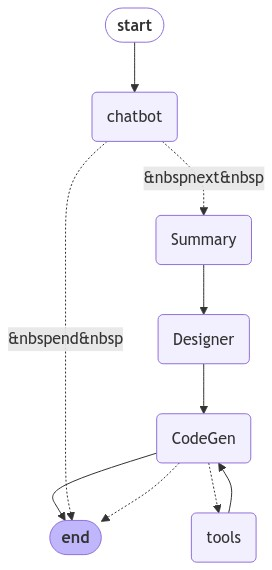

In [8]:

from IPython.display import Image, display  # 추가된 임포트


# 그래프 컴파일
memory = MemorySaver()

graph = workflow.compile(checkpointer=memory)

# LangGraph 시각화
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


Runnable Config 설정
---

In [9]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

Agentic Workflow 실행
---

In [ ]:

# 첫 질문
question = (
    "요구수명은 200시간, 입력속도는 1000 rpm, 부하토크는 200 Nm, 작동온도는 70도야, 기어비는 6이야"
)

for event in graph.stream(
    {
        "messages": [
            ("user", question)]}, 
    config=config,
    # interrupt_before=["tools"]
    ):
    for key, value in event.items():
        print(f"\n[{key}]\n")
        # print(f"\n[{value}]\n")

        value["messages"][-1].pretty_print()



[chatbot]

================================== Ai Message ==================================

기어박스 설계를 위해 다음 정보를 입력해 주세요:
1) 요구수명 (단위: hr)
2) 입력속도 (단위: RPM)
3) 부하토크 (단위: N.m)
4) 작동온도 (단위: deg)
5) 입출력 기어비 (현재 기어비: 6)
